# <font color='#2B4865'>**Hugging Face 🤗 Transformers Tutorial II**</font>

---
### Natural Language Processing
Date: Dec 21, 2022

Last Update: Nov 26, 2023

Author: Lorena Calvo-Bartolomé (lcalvo@pa.uc3m.es)

Version 1.1

---
This notebook is based on the [Hugging Face course](https://huggingface.co/course/chapter1/1) and documentation available at the Hugging Face website.

It constitutes the second tutorial notebook on the usage of Hugging Face libraries as well as its application for solving a series of NLP tasks.

Its main **goal** is to revise the specific inference and fine-tuning examples of the Question Answering and Summarization tasks at the same time that more advanced functionalities of the Hugging Face 🤗 Python library are learned.

---

<font color='#E0144C'>**For this notebook's execution, we highly encourage you to use Google Colaboratory. While for the inference part it is not necessary, you will highly speed up the execution if you make use of a GPU. For doing so, follow the following steps:**</font>

<font color='#E0144C'>**1. Connect to hosted runtime**</font>

<font color='#E0144C'>**2. Enable GPU setting by clicking Edit -> Notebook Settings -> Select GPU in Hardware Acceleration Tab -> Save**</font>

## <font color='#2B4865'>Installing necessary packages, imports and auxiliary functions</font>

In [ ]:
# Install necessary packages
import importlib, os

necessary_packages = ['transformers[sentencepiece,torch]', 'datasets', 'colored', 'wikipedia', 'evaluate', 'nltk', 'rouge_score']
def import_missing(packages):
  for p in packages:
    try:
      mod = importlib.import_module(p)
      print(f"Package {p} already installed!")
      packages.remove(p)
    except ModuleNotFoundError:
      print(f"Installing package {p}")
      with open("requirements.txt", 'w') as f:
        f.write("\n".join(str(i) for i in packages))
  if os.path.isfile("requirements.txt"):
    %pip install --quiet -r "requirements.txt"

import_missing(necessary_packages)

Installing package transformers[sentencepiece,torch]
Package datasets already installed!
Package wikipedia already installed!
Package nltk already installed!


In [ ]:
# Common imports
import os
import numpy as np
import pandas as pd
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import scipy
from colored import Fore, Back, Style
import torch
import json
import nltk
nltk.download("punkt")

# Figures plotted inside the notebook
%matplotlib inline
# High quality figures
%config InlineBackend.figure_format = 'retina'
# Figues size
plt.rcParams['figure.figsize'] = [8, 6]

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore',module='gradio')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <Style>
    pre {
        white-space: pre-wrap;
    }
  </Style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# For fancy table Display
%load_ext google.colab.data_table

In [ ]:
# Auxiliary funcion to print Trasnformer encodings
def print_encoding(model_inputs, indent=4):
    indent_str = " " * indent
    print("{")
    for k, v in model_inputs.items():
        print(indent_str + k + ":")
        print(indent_str + indent_str + str(v))
    print("}")

We are going to save all the files in this notebook generated into Drive. Fill the variable ``path_to_folder`` in the next with your Drive's folder in which you want to save the files.

In [ ]:
path_to_folder = '/content/drive/My Drive/NLP_IA'  # UPDATE THIS ACCORDING TO WHERE YOU WANT TO SAVE THE FILES!!!!

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Change to assignment directory
os.chdir(path_to_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## <font color='#2B4865'>**2. Question Answering**
---
</font>

**Question Answering (QA)** is the task of retrieving the answer to a question from a given text, which is useful for searching for an answer in a document. Some question answering models can even generate answers without context.

##### <font color='#2B4865'>**Architecture for approaching the task**</font>

There are different QA variants based on the inputs and outputs:

<table>
    <thead>
        <tr>
            <th> </th>
            <th><font color='#256D85'>Definition</font></th>
            <th><font color='#256D85'>Solved By</font></th>
            <th><font color='#256D85'>Good At</font></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><b>EXTRACTIVE</b></td>
            <td>The model extracts an answer from <br>a
            given context (e.g., a text, a <br>
            table, an HTML, etc.)
            </td>
            <td>Encoder-only models<br>(e.g., BERT)
            </td>
            <td>
            Answering factoid questions:<br> e.g.: "Who
            invented the transformers<br>
            architecture?"
            </td>
        </tr>
        <tr>
            <td><b>OPEN GENERATIVE</b></td>
            <td>The model generates free text<br>
            directly based on the context.
            </td>
            <td rowspan=2>Encoder-decoder models<br>
            (e.g., T5)</td>
            <td rowspan=2>Answering open-ended
            questions:<br>
            e.g.: "Why the sky is blue?"
            </td>
        </tr>
        <tr>
            <td><b>CLOSED GENERATIVE</b></td>
            <td>No context is provided so the<br>
            answer is generated completely by<br>
            the model.
            </td>
        </tr>
    </tbody>
</table>

##### <font color='#2B4865'>**Evaluation metrics**</font>

**Typical metrics** for Question Answering are:


*   **Exact-match**, which is based on the strict character match of the predicted answer and the right answer. For answers predicted correctly, the Exact Match will be $1$. Even if only one character is different, the Exact Match will be $0$.
*   **F1-Score** metric is useful if we value both false positives and false negatives equally. The F1-Score is calculated on each word in the predicted sequence against the correct answer. It ranges from $0$ to $1$, where $0$ is the worst possible score and $1$ is a perfect score indicating that the model predicts each observation correctly.

In the what is left of this section, we will be working with **Extractive Question Answering**.

### <font color='#2B4865'>*2.1. Inference*</font>

As you know from Section 1.1, the first step to perform inference with any Hugging Face pipeline is to find a model on [the hub](https://huggingface.co/models). Here, we will be using ``DistilBERT``, a Transformer model trained by distilling BERT base, that was proposed in [this paper](https://arxiv.org/pdf/1910.01108.pdf). In particular, we will be using [this fine-tune checkpoint](https://huggingface.co/distilbert-base-cased-distilled-squad) of ``DistilBERT-base-cased``.

###### **Exercise 2.1**

Create a QA pipeline named ``question_answerer`` by invoking ``pipeline()`` with the task identifier ``"question-answering"`` and the checkpoint mentioned above. What type of object does it return?

In [ ]:
checkpoint_name = "distilbert-base-cased-distilled-squad"

# <SOL>
# TODO: Add necessary imports


# TODO: Create pipeline
# </SOL>

After running the last cell, we have a pipeline for performing question answering given a context string. For example, the variable ``context1`` in the next cell defines the first few paragraphs from the [Wikipedia entry for David (son of Heraclius)](https://en.wikipedia.org/wiki/David_(son_of_Heraclius)) that we will be using as context.

In [ ]:
import wikipedia

context1 = wikipedia.summary("David (son of Heraclius)",auto_suggest=False).strip()
print(context1)

David (Greek: Δαυίδ; fl. 630–641) was one of three co-emperors of Byzantium for a few months in late 641, and had the regnal name Tiberius. David was the son of Emperor Heraclius and his wife and niece Empress Martina. He was born after the emperor and empress had visited Jerusalem and his given name reflects a deliberate attempt to link the imperial family with the Biblical David. The David Plates, which depict the life of King David, may likewise have been created for the young prince or to commemorate his birth. David was given the senior court title caesar in 638, in a ceremony during which he received the kamelaukion cap previously worn by his older brother Heraclonas.
After the death of Emperor Heraclius in February 641, when David was 10 years old, a power struggle ensued between different branches of the imperial family. As part of a compromise, David was raised to be co-emperor, ruling with his brother Heraclonas and their nephew Constans II. The Byzantine state faced serious 

In [ ]:
question1 = "What was the regnal name of David?"
r = question_answerer(question=question1, context=context1)
print(Fore.LIGHT_BLUE + Style.BOLD + f'Q: {question1}' + Style.RESET)
print(Fore.RED + "A: " + r['answer'] + Style.RESET)

Q: What was the regnal name of David?
A: Tiberius


We can also ask multiple questions at once by providing the pipeline with them  within a list:

In [ ]:
questions = ["Who was the father of David?",
             "What does David's name reflect?",
             "When did Emperor Heraclius die?"]

results = question_answerer(question=questions, context=context1)

for q, r in zip(questions, results):
  print(Fore.LIGHT_BLUE + Style.BOLD + f'Q: {q}' + Style.RESET)
  print(Fore.RED + "A: " + r['answer'] + Style.RESET)

Q: Who was the father of David?
A: Emperor Heraclius
Q: What does David's name reflect?
A: a deliberate attempt to link the imperial family with the Biblical David
Q: When did Emperor Heraclius die?
A: February 641


Although the models used in the Hugging Face pipelines generally give outstanding results, sometimes you will have particular examples where they don't perform so well. Let's use the following example with a context string about the [Golden Age of Comic Books](https://en.wikipedia.org/wiki/Golden_Age_of_Comic_Books):

In [ ]:
context2 = wikipedia.summary("Golden Age of Comic Books",auto_suggest=False).strip() + " " + \
           wikipedia.page("Golden Age of Comic Books").content\
            .split("=== World War II ===")[1]\
            .split("=== After the wars ===")[0].strip()
print(context2)

The Golden Age of Comic Books describes an era in the history of American comic books from 1938 to 1956. During this time, modern comic books were first published and rapidly increased in popularity. The superhero archetype was created and many well-known characters were introduced, including Superman, Batman, Robin, Captain Marvel, Captain America, and Wonder Woman. Between 1939 and 1941 Detective Comics and its sister company, All-American Publications, introduced popular superheroes such as Batman and Robin, Wonder Woman, the Flash, Green Lantern, Doctor Fate, the Atom, Hawkman, Green Arrow and Aquaman. Timely Comics, the 1940s predecessor of Marvel Comics, had million-selling titles featuring the Human Torch, the Sub-Mariner, and Captain America. Although DC and Timely characters are well remembered today, circulation figures suggest that the best-selling superhero title of the era was Fawcett Comics' Captain Marvel Adventures with sales of about 1.4 million copies per issue. The c

In [ ]:
questions = ["What popular superheroes were introduced between 1939 and 1941?",
             "What superheroes were introduced between 1939 and 1941 by Detective Comics and its sister company?",
             "What comic book characters were created between 1939 and 1941?",
             "What well-known characters were created between 1939 and 1941?",
             "What well-known superheroes were introduced between 1939 and 1941 by Detective Comics?"]

results = question_answerer(question=questions, context=context2)

for q, r in zip(questions, results):
  print(Fore.LIGHT_BLUE + Style.BOLD + f'Q: {q}' + Style.RESET)
  print(Fore.RED + "A: " + r['answer'] + Style.RESET)

Q: What popular superheroes were introduced between 1939 and 1941?
A: DC Comics' new Flash
Q: What superheroes were introduced between 1939 and 1941 by Detective Comics and its sister company?
A: DC Comics' new Flash
Q: What comic book characters were created between 1939 and 1941?
A: Superman, Batman, Robin, Captain Marvel, Captain America, and Wonder Woman
Q: What well-known characters were created between 1939 and 1941?
A: Superman, Batman, Robin, Captain Marvel, Captain America, and Wonder Woman
Q: What well-known superheroes were introduced between 1939 and 1941 by Detective Comics?
A: Plastic Man


As you can see, our pipeline is not giving us really good results for this example. This example belongs to the[ TyDi QA dataset](https://github.com/google-research-datasets/tydiqa), a dataset from Google for question/answering in diverse languages. To achieve better results, we need to consider fine-tuning our model.

But beFore entering into the fine-tuning part, let's see what is behind the ``QuestionAnswering`` pipeline.

#### <font color='#2B4865'>*2.1.1. Behind the QA pipeline*</font>

###### **Exercise 2.2**
Complete the following code to mimic the steps happening behind the QA pipeline above instantiated.

**Note:** Make sure you use the Fast version of the checkpoint's tokenizer. You can achieve this by checking the tokenizer's attribute ``is_fast`` once you have instantiated it.

In [ ]:
# <SOL>
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
## TODO: Add necessary imports

tokenizer = # TODO: Create tokenizer from checkpoint_name
model =  # TODO: Create model from checkpoint_name

inputs =  #TODO: Obtain tokenizer's output
outputs = # TODO: Obtain model's outputs
# </SOL>

In [ ]:
# <SOL>
## TODO: Check if you are using the Fast version of the tokenizer
# </SOL>

True

QA models work a little differently from what we have seen in Section 1 since they are trained on **predicting the index of the token starting the answer and the index of the token where the answer ends**. Because of this, these models **do not return one tensor of logits but two**: one for the logits corresponding to the start token of the answer, and one for the logits corresponding to the end token of the answer:

In [ ]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

torch.Size([1, 403]) torch.Size([1, 403])


**To convert those logits into probabilities**, we will apply a **softmax function**. Yet, before doing so, we need to make sure we **mask the indices that are not part of the context**.

One important thing to check before starting with the tokenization is **whether the model expects padding on the left or the right**:

In [ ]:
tokenizer.padding_side

'right'

Since our tokenizer expects padding on the right, we can pass to it **first the question and then the context together** (note that if ``padding_side`` were ``left``, we would switch the order of the question and the context), and it will properly insert the special tokens to form a sentence like:

```
[CLS] question [SEP] context [SEP]
```

Knowing how our input is, we need to **mask the tokens of the question as well as the ``[SEP]`` token**. Since some models use the ``[CLS]`` token to indicate that the answer is not in the context (as it is the case for our checkpoint), we will keep the ``[CLS]`` unmasked.

<br><center><img src="https://drive.google.com/uc?id=1aIGmJuZQ8-HCmEkbDVWDql7V8G0L1Hu7" width="60%"></center><br>

Since we will apply a softmax afterward, we just need to replace the logits we want to mask with a large negative number. We can identify the logits we want to mask by means of the ``sequence_ids()`` method, which  returns:

* ``None`` for the special tokens
*  $0$ or $1$ depending on whether the corresponding token comes from the first sentence past (the question) or the second (the context):

In [ ]:
sequence_ids = inputs.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
import torch

# Mask everything apart from the tokens of the context
mask = [i != 1 for i in sequence_ids]
# Unmask the [CLS] token
mask[0] = False
mask = torch.tensor(mask)[None]

start_logits[mask] = -10000
end_logits[mask] = -10000

Now that we have properly masked the logits corresponding to positions we don’t want to predict, we can apply the softmax:

In [ ]:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)[0]
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)[0]

At this stage, we could take the argmax of the start and end probabilities. However, by doing so we might end up with a ``start_index`` that is greater than the ``end_index``. To avoid this, we will compute the probabilities of each possible ``start_index`` and ``end_index`` under the condition that ``start_index <= end_index``, and then take the tuple ``(start_index,end_index)`` with the highest probability.

Assuming the events:
*   *E1 = "The answer starts at ``start_index``*
*   *E2 = "The answer ends at ``end_index``*

to be independent, the probability ``P`` that the answer starts at ``start_index``and ends at ``end_index`` is:

``P = start_probabilities[start_index] x end_probabilities[end_index]``

So, to compute all the scores, we just need to compute all the ``P`` for ``start_index <= end_index``.

In [ ]:
scores = start_probabilities[:, None] * end_probabilities[None, :]

Then we’ll mask the values where ``start_index > end_index`` by setting them to $0$ (the other probabilities are all positive numbers). The ``torch.triu()`` function returns the upper triangular part of the 2D tensor passed as an argument, so it will do that masking for us:

In [ ]:
scores = torch.triu(scores)

Now we just have to get the index of the maximum. Since PyTorch will return the index in the flattened tensor, we need to use the floor division ``//`` and modulus ``%`` operations to get the ``start_index`` and ``end_index``:

In [ ]:
max_index = scores.argmax().item()
start_index = max_index // scores.shape[1]
end_index = max_index % scores.shape[1]
print(scores[start_index, end_index])

tensor(0.9917, grad_fn=<SelectBackward0>)


###### **Exercise 2.3**

Compute the start and end indices for the **five** most likely answers.

In [ ]:
# <SOL>

# </SOL>

[(57, 59), (57, 60), (53, 59), (57, 76), (12, 59)]

We have the ``start_index`` and ``end_index`` of the answer in **terms of tokens**, so now we just need to convert them to the character indices in the context. However, due to the tokenization process, less frequent words may get split into subword units (as is the case for our tokenizer). We can easily deal with this through the tokenizer option ``return_offsets_mapping``. This will add a new key in the tokenizer's output, namely the ``offset_mapping`` which, **for each sub-token returned by the tokenizer**, gives us a **tuple indicating the sub-token's start position and end position** relative to the original token it was split from. Then, if we have the character offsets in the original text, we can map them with the output of the tokenizer:

*   the very first token ``([CLS])`` has ``(0, 0)`` because it doesn't correspond to any part of the question/answer
*   the second token returned by the tokenizer is the same as the characters $0$ to $4$ of the question
*   ...


In [ ]:
inputs_with_offsets = tokenizer(question1, context1, return_offsets_mapping=True)
offsets = inputs_with_offsets["offset_mapping"]

print(offsets[0:10])

[(0, 0), (0, 4), (5, 8), (9, 12), (13, 15), (15, 18), (18, 19), (20, 24), (25, 27), (28, 33)]


Finally, with the offsets we can find the start and end indices in the original context and get the answer based on them:

In [ ]:
start_char, _ = offsets[start_index] # start_char is the start index in the original context1
_, end_char = offsets[end_index] # end_char is the end index in the original context1
answer = context1[start_char:end_char]

result = {
    "answer": answer,
    "start": start_char,
    "end": end_char,
    "score": scores[start_index, end_index],
}
print(result)

{'answer': 'Tiberius', 'start': 130, 'end': 138, 'score': tensor(0.9917, grad_fn=<SelectBackward0>)}


### <font color='#2B4865'>*2.2. Fine-tuning*</font>

Here we will be fine-tuning a pre-trained DistilBERT model on the TyDi QA dataset. In particular, we will be using the same checkpoint that we used for the inference task (``distilbert-base-cased-distilled-squad``).

#### <font color='#2B4865'>*2.2.1. Loading in the dataset*</font>

Let's start by loading the [TyDi QA dataset from the Hub](https://huggingface.co/datasets/tydiqa). If you check the documentation, you will see that the dataset provides two types of tasks (primary and secondary). Yet, here we will only be making use of the primary task, since as the authors stated "*these are a fuller and more robust representative of information-seeking question answering*". Once we have the dataset, we will keep only English samples.

###### **Exercise 2.4**

Download the TyDi QA dataset for the primary tasks from the Hub. Save the ``DatasetDict`` object in a variable named ``tydiqa_dataset``.

**Hint:** Make use of the parameter ``task`` to specify for which tasks we are going to prepare the dataset:

From the docs: [``datasets.load_dataset``](https://huggingface.co/docs/datasets/v2.15.0/en/package_reference/loading_methods#datasets.load_dataset)

* **Parameters**
  * ``path (str)`` — Path or name of the dataset. Depending on path, the dataset builder that is used comes from a generic dataset script (JSON, CSV, Parquet, text etc.) or from the dataset script (a python file) inside the dataset directory. -> The one we have been using until now.
  * ``task (str)`` — The task to prepare the dataset for during training and evaluation. Casts the dataset’s Features to standardized column names and types as detailed in datasets.tasks.


In [ ]:
# <SOL>

# <SOL>

tydiqa_dataset

DatasetDict({
    train: Dataset({
        features: ['passage_answer_candidates', 'question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
        num_rows: 166916
    })
    validation: Dataset({
        features: ['passage_answer_candidates', 'question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
        num_rows: 18670
    })
})

For the purpose of this example, we exclusively focus on English samples by filtering out any non-English ones:

In [ ]:
# We filter out non-English samples
tydiqa_dataset = tydiqa_dataset.filter(lambda example: example['language'] == 'english')
print()

tydiqa_dataset

DatasetDict({
    train: Dataset({
        features: ['passage_answer_candidates', 'question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
        num_rows: 9211
    })
    validation: Dataset({
        features: ['passage_answer_candidates', 'question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
        num_rows: 1031
    })
})

As you can see, this dataset consists of:

*   ``passage_answer_candidates`` for the Passage selection task, that we are not going to use
*   questions (``question_text``)
*   contexts (``document_plaintext``)
*   information related to the oringal document the context comes (``document_title``, ``language``, and ``document_url``)
*   and a dictionary accessible through the ``annotations`` key containing:
  * the index of the passage index candidate (``passage_answer_candidate_index``)    
  * the point to the start and end position of the answer inside the context (``minimal_answers_start_byte`` and ``minimal_answers_end_byte``). If the question is a "yes/no" answer or unanswerable, the former indexes will be equal to ``-1``.
  * whether the question has a "yes/no" answer (``yes_no_answer``)

Prior to moving forward, we eliminate the ``passage_answer_candidates`` as it won't be utilized in subsequent steps:

In [ ]:
tydiqa_dataset =  tydiqa_dataset.remove_columns(["passage_answer_candidates"])

###### **Exercise 2.5**


To have easier access to each of the features in the dataset, let's transform its current nested structure of several types into separate columns using the ``Dataset.flatten()`` method.

Once you have the flattened dataset, complete the code in the cell below to display an example's Question, Context, and True answer. Truncate the context to 512 words.



In [ ]:
tydiqa_dataset = # TODO: flatten the dataset
tydiqa_dataset

DatasetDict({
    train: Dataset({
        features: ['question_text', 'document_title', 'language', 'annotations.passage_answer_candidate_index', 'annotations.minimal_answers_start_byte', 'annotations.minimal_answers_end_byte', 'annotations.yes_no_answer', 'document_plaintext', 'document_url'],
        num_rows: 9211
    })
    validation: Dataset({
        features: ['question_text', 'document_title', 'language', 'annotations.passage_answer_candidate_index', 'annotations.minimal_answers_start_byte', 'annotations.minimal_answers_end_byte', 'annotations.yes_no_answer', 'document_plaintext', 'document_url'],
        num_rows: 1031
    })
})

In [ ]:
idx = 500

start_index = # TODO: Get start index of the answer in the context

end_index = # TODO: Get end index of the answer in the context

question = # TODO: Get question

context = # TODO: Get truncated context

answer = # TODO: Get true answer

print(Fore.LIGHT_BLUE + Style.BOLD + 'Question: ' + Style.RESET + question)
print(Fore.LIGHT_GREEN + Style.BOLD + '\nContext (truncated): ' + Style.RESET + context + '...')
print(Fore.LIGHT_RED + Style.BOLD + '\nAnswer: ' + Style.RESET  + answer)

Question: What is the most used language in Europe?

Context (truncated): 


The languages of the European Union are languages used by people within the member states of the European Union (EU).
The EU has 24 official languages, of which three (English, French and German) have the higher status of "procedural" languages[4] of the European Commission (whereas the European Parliament accepts all official languages as working languages[5]). One language (Irish) previously had the lower status of "treaty language" before being upgraded to an official and working language in 2007, alt...

Answer: English


BeFore starting with the preprocessing, we will create a test subset from the validation one so we have one set for testing that has not been seen during the training of the model. Also, to make the training faster, we will extract a subset from each of the latter.

###### **Exercise 2.6**
To generate the final dataset that we are going to use, perform the following steps:

1.   Split the validation subset with an $80/20$ ratio
2.   Select the first $3000$ entries from the original train set as the final train set.
3.   Assign as test and validation subsets the result of splitting the original validation subset: The first $800$ samples of the resulting training subset after the train_test_split will be the final validation set, and the first $200$ of the test subset, the final test set.

In [ ]:
# <SOL>

# <SOL>
tydiqa_dataset

DatasetDict({
    train: Dataset({
        features: ['question_text', 'document_title', 'language', 'annotations.passage_answer_candidate_index', 'annotations.minimal_answers_start_byte', 'annotations.minimal_answers_end_byte', 'annotations.yes_no_answer', 'document_plaintext', 'document_url'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['question_text', 'document_title', 'language', 'annotations.passage_answer_candidate_index', 'annotations.minimal_answers_start_byte', 'annotations.minimal_answers_end_byte', 'annotations.yes_no_answer', 'document_plaintext', 'document_url'],
        num_rows: 800
    })
    test: Dataset({
        features: ['question_text', 'document_title', 'language', 'annotations.passage_answer_candidate_index', 'annotations.minimal_answers_start_byte', 'annotations.minimal_answers_end_byte', 'annotations.yes_no_answer', 'document_plaintext', 'document_url'],
        num_rows: 200
    })
})

#### <font color='#2B4865'>*2.2.2. Dataset preprocessing*</font>

Let's first convert the text in the input into IDs the model can make sense of, using a tokenizer.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint_name)

We know from the previous subsection that our tokenizer expects **padding on the right**, so to tokenize our data we will input first the question and then the context, getting something as follows:

```
[CLS] question [SEP] context [SEP]
```

The **labels** will then be the **index of the tokens starting and ending the answer**, and the model will be tasked to predict **one start and end logit** per token in the input, with the theoretical labels being as follow:

<br><center><img src="https://drive.google.com/uc?id=1KHPILmRPTp_i4WaksmepLsFAvg8beBL_" width="60%"></center><br>

Below is the ``preprocess_dataset`` function for the extractive question-answering task. When calling the tokenizer, note the following:

* Tokenization truncates only the context; specify this with ``truncation="only_first"`` or ``truncation="only_second"`` based on where padding is expected.
* Padding is set to the model's maximum supported length.
* Set ``return_offsets_mapping``to True so we can map each sub-token's start position and end position relative to the original token it was split from.

After tokenization, we remove the text features that are in the dataset.

In [ ]:
def preprocess_dataset(examples):

    # Carry out tokenization
    questions = [q.strip() for q in examples["question_text"]]
    inputs = tokenizer(
        questions,
        examples["document_plaintext"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Extract offset mappings from the inputs
    offset_mapping = inputs.pop("offset_mapping")

    # Lists to store start and end positions for each example
    start_positions = []
    end_positions = []

    # Iterate over examples in the batch and their corresponding offset mappings
    for i, offset in enumerate(offset_mapping):

        # Extract the start and end character positions of the minimal answer
        start_char = examples["annotations.minimal_answers_start_byte"][i][0]
        end_char = examples['annotations.minimal_answers_end_byte'][i][0]
        answer = examples["document_plaintext"][i][start_char:end_char]

        # Get sequence_ids for the current example
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
# <SOL>
tokenized_tydiqa_dataset = tydiqa_dataset.map(preprocess_dataset, remove_columns=tydiqa_dataset["train"].column_names, batched=True)
# </SOL>

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
tokenized_tydiqa_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 800
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 200
    })
})

#### <font color='#2B4865'>*2.2.3. Fine-tuning*</font>

We will be using there the F1 score as a metric to evaluate our model's performance, as defined in the ``compute_f1_metrics`` function below.

In [ ]:
from sklearn.metrics import f1_score

def compute_f1_metrics(pred):
    start_labels = pred.label_ids[0]
    start_preds = pred.predictions[0].argmax(-1)
    end_labels = pred.label_ids[1]
    end_preds = pred.predictions[1].argmax(-1)

    f1_start = f1_score(start_labels, start_preds, average='macro')
    f1_end = f1_score(end_labels, end_preds, average='macro')

    return {
        'f1_start': f1_start,
        'f1_end': f1_end,
    }

###### **Exercise 2.7**
Carry out the fine-tuning of the model. Do not make use of dynamic padding as we have already included padding during the tokenization.

Once complete, evaluate the performance of the model with the test set.

In [ ]:
# <SOL>

# </SOL>

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1 Start,F1 End
1,1.309100,1.351250,0.213547,0.144109
2,0.907000,1.355567,0.185121,0.162478


TrainOutput(global_step=376, training_loss=1.1080421691245221, metrics={'train_runtime': 293.9, 'train_samples_per_second': 102.076, 'train_steps_per_second': 6.397, 'total_flos': 587938950144000.0, 'train_loss': 1.1080421691245221, 'epoch': 2.0})

In [ ]:
trainer.evaluate(tokenized_tydiqa_dataset['test'])

{'eval_loss': 1.3274760246276855,
 'eval_f1_start': 0.16458530432040366,
 'eval_f1_end': 0.18496764151716227,
 'eval_runtime': 2.6827,
 'eval_samples_per_second': 74.552,
 'eval_steps_per_second': 4.846,
 'epoch': 2.0}

#### <font color='#2B4865'>*2.2.4. Make predictions with the fine-tuned model*</font>

We can now test our fine-tuned model. Let's first check how it answers the questions about the Golden Age of Comic Books:

In [ ]:
checkpoint = 376
checkpoint_new = f"{path_to_folder}/{checkpoint_name}-finetuned-tydiqa/checkpoint-{checkpoint}" ## TODO: Update this path to the last saved checkpoint in the former cell

In [ ]:
questions = ["What popular superheroes were introduced between 1939 and 1941?",
             "What superheroes were introduced between 1939 and 1941 by Detective Comics and its sister company?",
             "What comic book characters were created between 1939 and 1941?",
             "What well-known characters were created between 1939 and 1941?",
             "What well-known superheroes were introduced between 1939 and 1941 by Detective Comics?"]

question_answerer = pipeline(task='question-answering', model=checkpoint_new)

results = question_answerer(question=questions, context=context2)

for q, r in zip(questions, results):
  print(Fore.LIGHT_BLUE + Style.BOLD + f'Q: {q}' + Style.RESET)
  print(Fore.RED + "A: " + r['answer'] + Style.RESET)

Q: What popular superheroes were introduced between 1939 and 1941?
A: Batman and Robin, Wonder Woman
Q: What superheroes were introduced between 1939 and 1941 by Detective Comics and its sister company?
A: Batman and Robin, Wonder Woman
Q: What comic book characters were created between 1939 and 1941?
A: Superman, Batman, Robin, Captain Marvel, Captain America, and Wonder Woman
Q: What well-known characters were created between 1939 and 1941?
A: Superman, Batman, Robin, Captain Marvel, Captain America, and Wonder Woman
Q: What well-known superheroes were introduced between 1939 and 1941 by Detective Comics?
A: Superman, Batman, Robin, Captain Marvel, Captain America, and Wonder Woman


You should see an improvement in the answer in comparison to what we were obtaining before the fine-tuning.

#### <font color='#2B4865'>*2.2.5. Some final notes about fine-tuning a Q&A system*</font>

Though, you should note that even when we improved the performance of our Question Answering system, it still does not perform perfectly. You can test this by checking how it answers some of the questions in the test set. The main reason behind this is that we are truncating the contexts, which leads to losing the answer we are looking for on many occasions. Hugging Face does provide a better way of handling long contexts: let the long examples in our dataset give several input features, each of length shorter than the maximum length of the model. This can be achieved via the parameter ``return_overflowing_tokens=True`` and some additional configuration. If you want to know more about the topic, you can check [Hugging Face documentation about it](https://huggingface.co/course/chapter6/3b?fw=pt).

You should also take into account that here we have used the F1 score as a metric to evaluate our model's performance. Yet, using this metric is just a simplification of how to deal with the evaluation, since it is based on the start and end values predicted by the model. If you want to dig deeper into other metrics that can be used for a Q&A, you can also check [this colab notebook](https://github.com/huggingface/notebooks/blob/main/examples/question_answering.ipynb) resource from the Hugging Face team.

## <font color='#2B4865'>**3. Summarization**
---
</font>

**Summarization** is the task of producing a shorter version of a document while preserving its important information. Along with translation, it is another example of a task that can be formulated as a **sequence-to-sequence** task, i.e., we can formulate it as going from one sequence to another.

##### <font color='#2B4865'>**Architecture for approaching the task**</font>

As we saw in the introductory session, there exist two types of summarization:
* **Extractive**, when the summary consists of text extracted from the original input.
* **Abstractive**, when the models can generate entirely new text.

Accordingly, to its **sequence-to-sequence nature**, most Transformer models for summarization adopt the **encoder-decoder** architecture, although there are **some exceptions like the GPT family** of models which can also be used for summarization in few-shot settings.

##### <font color='#2B4865'>**Evaluation metrics**</font>

In comparison to the other tasks that we have covered in this tutorial, measuring the performance of text generation tasks such as summarization or translation is not straightforward.

For instance, let's imagine that we want to generate a summary for the sentence "*I loved watching Spiderman*". We can find multiple valid summaries, such as "*I loved Spiderman*" or "*Spiderman is a great movie"*. Due to this, attempting to measure the performance by matching the generated summary and the label is not a good solution.

For summarization, one of the most commonly used metrics is the **ROUGE score** (Recall-Oriented Understudy for Gisting Evaluation). Its basic idea is to compare a generated summary against a set of reference summaries that are typically created by humans.

More precisely, suppose we want to compare the following two summaries:
```
generated_summary = "I absolutely loved watching Spiderman"
reference_summary = "I loved watching Spiderman"
```

One way of comparing them would be to count the number of overlapping words ($6$ here). Since this is not really refined, ROUGE alternatively computes a metric based on the precision and recall scores for the overlap

The **recall** measures how much of the reference summary is captured by the generated one. If we are just comparing words, recall can be calculated as follows:

$$Recall = \frac{\text{Number of overlapping words}}{\text{Total number of words in reference summary}}$$


For the above example, the recall takes a value of $4/4=1$, i.e., a perfect recall (all the words in the reference summary have been produced by the model). Still, we could have that the generated summary was "*I really really loved watching Spiderman all night*" which will have also a perfect recall, even though it is a much worse summary (it is verbose).  

To deal with the former scenarios, we utilize the **precision** to measure how much of the generated summary was relevant as:

$$Precision = \frac{\text{Number of overlapping words}}{\text{Total number of words in generated summary}}$$


Applying this to our verbose summary gives a precision of $4/8 = 0.5$, which is considerably worse than the precision of $4/5 = 0.8$ obtained by our shorter one. In practice, both precision and recall are usually computed, and then the F1-score (the harmonic mean of precision and recall) is reported.

### <font color='#2B4865'>*3.1. Inference*</font>

As we have seen in the previous sections, we can perform inference on any task by means of a pipeline. For the specific case of summarization, we just need to add the task identifier ``summarization``, in addition to the checkpoint model we want to use; when the latter is not specified, the default model will be used ([``sshleifer/distilbart-cnn-12-6``](https://huggingface.co/sshleifer/distilbart-cnn-12-6)).

###### **Exercise 3.1**

Choose a model for English summarization [from the Hub](https://huggingface.co/models?pipeline_tag=summarization) (but different from the pipeline's default) and use it to create a summarization pipeline. Extract any text from the Wikipedia of your choice through the Wikipedia API and use the pipeline to summarize it. The task identifier for the summarization task is ``summarization``.

In [ ]:
# <SOL>

# </SOL>

In [ ]:
# <SOL>
import wikipedia

text_to_summarize = # TODO
summary = # TODO
# <SOL>

print(Fore.LIGHT_BLUE + Style.BOLD + 'Text to summarize:' + Style.RESET)
print(text_to_summarize)
print()
print(Fore.LIGHT_BLUE + Style.BOLD + 'Summary:' + Style.RESET)
print(summary[0]['summary_text'])

Text to summarize:
In statistics and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently: "dog" and "bone" will appear more often in documents about dogs, "cat" and "meow" will appear in documents about cats, and "the" and "is" will appear approximately equally in both. A document typically concerns multiple topics in different proportions; thus, in a document that is 10% about cats and 90% about dogs, there would probably be about 9 times more dog words than cat words. The "topics" produced by topic modeling techniques are clusters of similar words. A topic model captures this intuition in a mathematical framework, which allows e

This works pretty well. However, if our objective is to generate summaries in a specific context, a fine-tuned model in such a context will be a better match. Let's see how to fine-tune a model for making summaries out of English news.

### <font color='#2B4865'>*3.2. Fine-tuning*</font>

#### <font color='#2B4865'>*3.2.1. Loading in the dataset*</font>

We will use the [CNN Dailymail Datasets](https://huggingface.co/datasets/cnn_dailymail) dataset to create our ad-hoc summarizer. It consists of English  news articles written by journalists at CNN and the Daily Mail.

###### **Exercise 3.2**

Download the version "3.0.0" from the CNN Dailymail Dataset. Save the ``DatasetDict`` object in variable named ``cnn_dataset``. To download the subset specific to the asked version, you just need to add the identifier, in this case ``3.0.0``, to the dataset loading function.

In [ ]:
# <SOL>

# </SOL>
cnn_dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

As shown, we have $287,113$, $13,368$, and $501,149,000$ article-highlight pairs for the train, validation, and test sets, respectively. Given the large volume of data, we'll choose a subset of $3,000$, $800$, and $200$ samples for the train, validation, and test sets in this notebook.

In [ ]:
cnn_dataset = DatasetDict({
    "train": cnn_dataset["train"].select(range(3000)),
    "val": cnn_dataset["validation"].select(range(800)),
    "test": cnn_dataset["test"].select(range(200)),
})

Now, let's display a few samples to gain insight into their characteristics:

In [ ]:
def show_samples(dataset, num_samples=2, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(Fore.LIGHT_BLUE + Style.BOLD + '\n>> Highlights:' + Style.RESET, example['highlights'])
        print(Fore.GREEN + Style.BOLD + '>> Article:' + Style.RESET, example['article'])
        print({"-" * 10})

show_samples(cnn_dataset, num_samples=5)


>> Highlights: Julian E. Zelizer: The Obama presidency resembles that of Lyndon B. Johnson .
Zelizer says both aimed high and worked skillfully with congressional leaders .
A president can shape legislation without dictating the details, professor says .
Zelizer: Obama has gotten big results from Congress by keeping leaders on his side .
>> Article: Editor's note: Julian E. Zelizer is a professor of history and public affairs at Princeton University's Woodrow Wilson School. His new book, "Arsenal of Democracy: The Politics of National Security -- From World War II to the War on Terrorism," will be published this fall by Basic Books. Zelizer writes widely on current events. Julian E. Zelizer says so far the Obama presidency resembles that of Lyndon B. Johnson. PRINCETON, New Jersey (CNN) -- While pundits have compared President Obama to Franklin Delano Roosevelt, John F. Kennedy, Jimmy Carter and Ronald Reagan, less attention has been paid to another, perhaps more apt parallel -- Lyndo

Now that we have a training corpus, one final thing to check is the distribution of words in the articles-hightlights pairs. This is especially important for summarization tasks, where short reference summaries in the data can bias the model to only output one or two words in the generated summaries.

###### **Exercise 3.3**

Plot two histograms: one for the word distribution in the reviews and another one for those in the titles (summaries) in the **train** subset. Also, calculate the average number of tokens per review and summary. For easiness, convert the training dataset into a Pandas DataFrame.

You can convert a ``DatasetDict`` object into a ``pandas.DataFrame`` by applying ``DatasetDict.set_format("pandas")``.

Once you are finished with the exercise, do not forget to restore the dataset to its original format with the ``reset_format()`` method.

In [ ]:
# <SOL>
# TODO: Transform cnn_dataset into pandas DataFrame and take train subset

# TODO: Tokenize train subset's documents and summaries

# TODO: Save tokenized subsets in dataframe

# </SOL>

Average number of tokens per review: 605.7106666666666
Average number of tokens per summary: 43.471333333333334


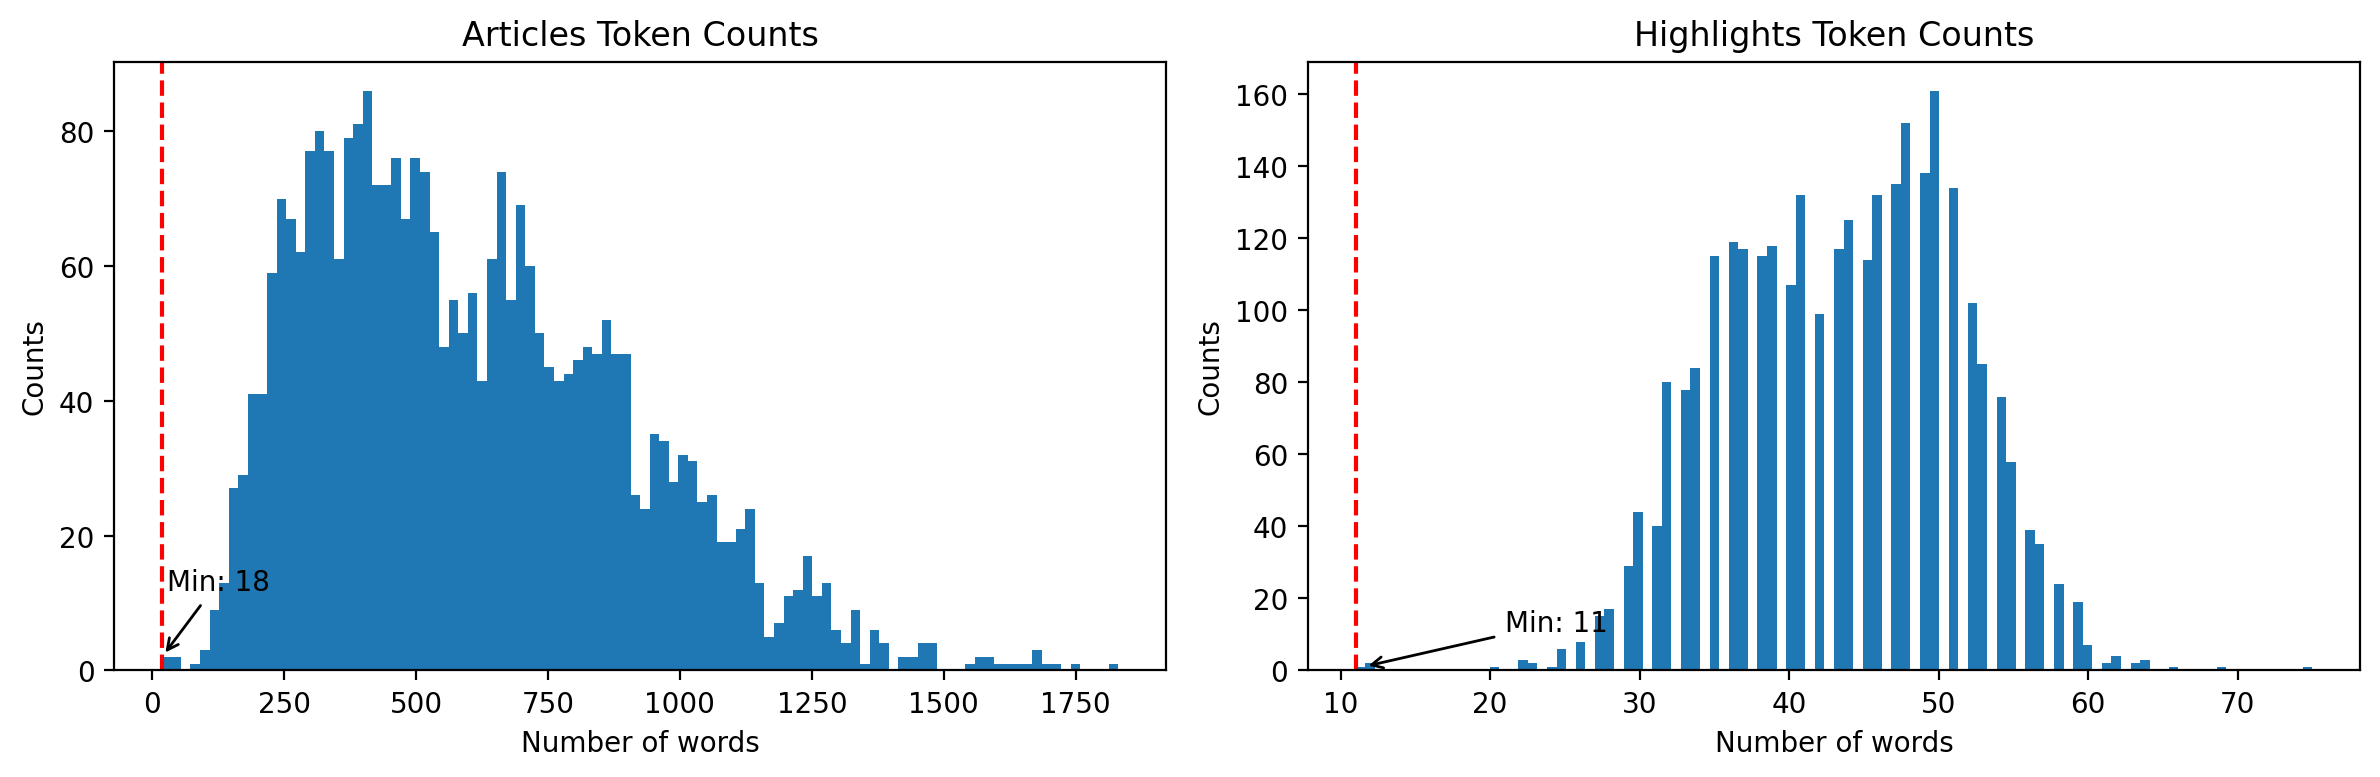

In [ ]:
# <SOL>
# TODO: Plot histograms

# </SOL>

In [ ]:
# <SOL>
# TODO: Reset format of cnn_dataset

# </SOL>

The distribution of both articles and highlights is generally well-balanced, requiring no additional processing at this stage. It's worth noting, however, that if, for instance, the highlights were heavily skewed towards 0 words, filtering out examples with very short titles may be necessary to ensure our model generates more meaningful summaries.

Now that we have our dataset ready, it is time to look for the model. In this case, we are going to use the small version of the **T5** model.

As we saw in class, in T5, every NLP task is defined in terms of a prompt prefix, such as summarise, which causes the model to adjust the output text to the prompt, thus making T5 quite versatile in the sense that solves many tasks within a single model:

<br><center><img src="https://drive.google.com/uc?id=1OFzqv_1NCqoc_sRzwsK154XOCOIcZHG6" width="60%"></center><br>



#### <font color='#2B4865'>*3.2.2. Dataset preprocessing*</font>

Our next task is to **tokenize and encode** our document-summary pairs. We will be using ``t5-small`` as our model checkpoint.

###### **Exercise 3.4**

Load the tokenizer associated with the pretrained model checkpoint.

In [ ]:
# <SOL>
model_checkpoint = "t5-small"
tokenizer = # TODO
# </SOL>

Let’s start by testing out the T5 tokenizer on a small example:

In [ ]:
inputs = tokenizer("I loved watching Spiderman!")
print_encoding(inputs)

{
    input_ids:
        [27, 1858, 3355, 18617, 348, 55, 1]
    attention_mask:
        [1, 1, 1, 1, 1, 1, 1]
}


As usual, we see the ``input_ids`` and ``attention_mask`` we have been dealing with until now. Let’s decode these input IDs to see the kind of tokenizer we’re utilzing:

In [ ]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

['▁I', '▁loved', '▁watching', '▁Spider', 'man', '!', '</s>']

The special Unicode character ▁ and end-of-sequence token </s> indicate that we’re dealing with the **SentencePiece tokenizer**.

> **Unigram:** Subword tokenization algorithm introduced [here](https://arxiv.org/pdf/1804.10959.pdf). Instead of starting with a group of base symbols and learning merges with some rule, like BPE, it starts from a large vocabulary (for instance, all pretokenized words and the most common substrings) that it will trim down progressively.

> **SentencePiece:** Tokenization algorithm that is agnostic about accents, punctuation, and the fact that many languages, like Japanese, do not have whitespace characters. It achieves this by treating the input as a raw stream, including the space in the set of characters to use and then using the unigram tokenization to construct the appropriate vocabulary. The ‘▁’ characters represent here spaces.

To tokenize our corpus, we must contend with a summarization-related complication: because our labels are also text, they may exceed the model's maximum context size. To avoid passing extremely long inputs to our model, we must apply truncation to both the articles and their highlights. Transformers' tokenizers allow us to do this via the ``text_target`` argument, thanks to which we can tokenize the labels in parallel to the inputs.

###### **Exercise 3.5**

Implement the function ``preprocess_dataset`` that carries out the preprocessing of the inputs and targets for T5. Note that the variables ```max_input_length``` and ```max_target_length``` define the upper limits for how long the documents and summaries are going to be.

Take into account the following for the implementation of the ``preprocess_dataset`` function:

*  You need to call the tokenizer twice: once for carrying out the preprocessing of the articles (``article``) and once for that of the summaries (``highlights``).
*  For the tokenization of the reviews:
  * Prefix the inputs with ``"summarize:"``
  * Use the options ``max_length=max_input_length`` and ``truncation=True``.
*  For the tokenization of the summaries:
  * Use the options ``max_length=max_target_length`` and ``truncation=True``.


Once the preprocessing function is defined, use the ``map()`` function to apply it to the whole dataset. For doing so, use the following parameters:
*   ```batched=True``` to operate with batches of example (of default batch size $1,000$)
*   ```remove_columns``` to get rid of the string columns that we do not need anymore

In [ ]:
max_input_length = 1024
max_target_length = 128

def preprocess_dataset(examples):
    # <SOL>
    # TODO: Implement body

    # </SOL>
    return model_inputs

# <SOL>
# TODO: Tokenize dataset
tokenized_cnn_dataset = cnn_dataset.map(preprocess_dataset, batched=True, remove_columns=cnn_dataset["train"].column_names)
# <SOL>

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [ ]:
cnn_dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 800
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 200
    })
})

#### <font color='#2B4865'>*3.2.3. Fine-tuning*</font>

As evaluation metrics, we are going to use the ROUGE score explained in the Summarization introduction, which is available within the ```rouge_score``` package:

In [ ]:
import evaluate

rouge_score = evaluate.load("rouge")

In [ ]:
generated_summary = "I absolutely loved watching Spiderman"
reference_summary = "I loved watching Spiderman"

In [ ]:
scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

{'rouge1': 0.888888888888889,
 'rouge2': 0.5714285714285715,
 'rougeL': 0.888888888888889,
 'rougeLsum': 0.888888888888889}

We can see that the output is a dictionary with a variety of ROUGE scores which are based on different types of text granularity when comparing the generated and reference summaries. From these, the ```rouge1``` variant is the metric we have discussed in the introduction. ```rouge2``` measures the overlap between bigrams (pairs of words), while ```rougeL``` and ```rougeLsum``` measure the longest matching sequences of words by looking for the longest common substrings in the generated and reference summaries. The difference between the latter two comes from the fact that ```rougeLsum``` is computed over a whole summary, while ```rougeL```is the average over individual sentences.

We are going to use these ROUGE scores to track the performance of our model, but first, we must define a strong baseline. For text summarization, it is pretty common to attain this baseline by taking the first three sentences of a baseline (the lead-3 baseline). To track the sentence boundaries, we could use full stops, but this will fail on acronyms such as U.S.A. Hence, we will use nltk's sentence tokenizer instead.

###### **Exercise 3.6**

Implement the body of the function ```three_sentence_summary``` which given an example in our dataset, it returns the first three sentences in its document. Return the three found sentences joined with a  newline (```"\n"```). Test it on a training example.

In [ ]:
# <SOL>
from nltk.tokenize import sent_tokenize

def three_sentence_summary(text):
    # TODO: Implement body
    return summary

print(three_sentence_summary(cnn_dataset["train"][1]["article"]))
# </SOL>

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."


###### **Exercise 3.7**

Implement the body of the function ```evaluate_lead3_baseline```, which given a dataset and an instance of the metric class, computes the given metric for the three sentence summaries extracted from the dataset. Then use this function to compute the ROUGE scores over the validation set.

In [ ]:
# <SOL>
def evaluate_lead3_baseline(dataset, metric):
    # TODO: Implement body
    return score
# </SOL>

score_dict = evaluate_lead3_baseline(cnn_dataset["val"], rouge_score)
score_dict

{'rouge1': 27.587462923326456,
 'rouge2': 10.356732932817884,
 'rougeL': 18.638068385674504,
 'rougeLsum': 24.66859712196244}

Now that we have baseline scores to compare with, we can start with the fine-tuning of our model. Let's start by loading the pretrained model from the t5-small checkpoint.

###### **Exercise 3.8**

Load the pretrained model in a variable named ``model``. For doing so, take into account that Summarization is a **sequence-to-sequence** task when you create your AutoModel instance.

In [ ]:
# <SOL>

# </SOL>

If you’re wondering why you don’t see any warnings about fine-tuning the model on a downstream task, that’s because **for sequence-to-sequence tasks we keep all the weights of the network**; this is different from what we have encountered until now, where the head of the pretrained model was replaced with a randomly initialized network.

Fine-tuning a model for summarization is very similar to what have been doing until now for other tasks, but with a few exceptions:

1. To compute the ROUGE scores, we need to generate summaries. 🤗 Transformers makes this automatically for us through two dedicated classes ``Seq2SeqTrainingArguments`` and ``Seq2SeqTrainer``. Hence, instead of instantiating objects from the classes ``TrainingArguments`` and ``Trainer``, we will use the Seq2Seq-specific ones.
  * When using the ``Seq2SeqTrainingArguments`` class, we need to care of the following arguments:
      * ``predict_with_generate=True`` to generate summaries during evaluation so that we can compute ROUGE scores for each epoch. The Transformer's decoder performs inference by predicting tokens one by one, and this is implemented by the model’s ``generate()`` method. Setting ``predict_with_generate=True`` tells the Seq2SeqTrainer to use that method for evaluation.
      *   ``save_total_limit`` to limit the number of checkpoints saved during training. This is necessary since even the "small" version of T5 uses around a GB of hard drive space, and we can save a bit of room by limiting the number of copies we save.
  * The usage of the ``Seq2SeqTrainer`` class is equivalent to that of the ``Trainer`` class.
2. Since T5 is an **encoder-decoder Transformer model**, during decoding, we need to shift the labels to the right by one when preparing our batches. This is necessary to ensure that the decoder only sees the previous ground truth labels and not the current or future ones, which would be easy for the model to memorize. 🤗 Transformers provides a ``DataCollatorForSeq2Seq`` collator that will dynamically pad the inputs and the labels for us. The way we instantiate this collator is by providing the tokenizer and model. From this dynamic padding, there are two main things that we need to take into account:
  * ``input_ids`` and ``attention_mask`` of shorter sentences get padded on the right with a [PAD] token (whose ID is 0)
  * its associated labels are padded with $-100$s, to make sure the padding tokens are ignored by the loss function.

Having this in mind, proceed with the following exercises to complete the fine-tuning.

###### **Exercise 3.9**

Implement the body of the ``compute_metrics`` function by following the provided guidelines.

In [ ]:
def compute_metrics(eval_pred):
    # <SOL>

    preds, labels = eval_pred

    decoded_preds = # TODO: Decode generated summaries of a whole batch at once into text. Skip special_tokens

    labels = # TODO: Replace -100 in the labels by the "pad_token_id"

    decoded_labels = # TODO: Decode reference summaries into text of a whole batch at once into text. Skip special_tokens

    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]

    score = # TODO: Compute ROUGE scores

    score = {key: value * 100 for key, value in score.items()}

    # <SOL>
    return score

###### **Exercise 3.10**

Carry out the fine-tuning. For doing so:

1. Define your training arguments by creating an instance of the ``Seq2SeqTrainingArguments`` class. Utilize, **at least**, the following configuration:
  * ``save_total_limit=3``
  * ``predict_with_generate=True``
  
  Try fine-tuning other parameters (e.g., learning_rate, weight_decay, eval_steps, nr epochs etc.)
2. Create a ``DataCollatorForSeq2Seq`` object.
3. Create a ``Seq2SeqTrainer`` object by passing all the objects until now created (model, training_args, tokenizer, etc.) Use the compute_metrics function we defined in Exercise 3.10 for evaluating the model during training.
4. Train and evaluate the model.

Save the fine-tuned model.

How are the evaluation scores of our fine-tuned model? Does it outperform our lead-3 baseline?

In [ ]:
# <SOL>

# TODO: Add imports

training_args = # TODO

trainer = # TODO

In [ ]:
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.032100,2.002954,24.485941,9.088702,19.785590,22.241066
2,1.895400,2.005943,23.814575,8.921603,19.346105,21.766360
3,1.863200,2.017755,24.131540,8.991544,19.556298,21.938851


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=2250, training_loss=1.9319733208550347, metrics={'train_runtime': 1074.5493, 'train_samples_per_second': 22.335, 'train_steps_per_second': 5.584, 'total_flos': 2352957398188032.0, 'train_loss': 1.9319733208550347, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'eval_loss': 2.0029544830322266,
 'eval_rouge1': 24.485941480924698,
 'eval_rouge2': 9.08870153531135,
 'eval_rougeL': 19.7855897173772,
 'eval_rougeLsum': 22.241065951663842,
 'eval_runtime': 89.7221,
 'eval_samples_per_second': 8.916,
 'eval_steps_per_second': 2.229,
 'epoch': 3.0}

#### <font color='#2B4865'>*3.2.4. Make predictions with the fine-tuned model*</font>

We can no play with our saved model either via the inference widget or with a pipeline object, as follows:

In [ ]:
# Load trained model
from transformers import pipeline
checkpoint = 2250
model_path = f"{path_to_folder}/{model_checkpoint}-finetuned-cnn/checkpoint-{checkpoint}" ## TODO: Update this path to the last saved checkpoint in the former cell
summarizer = pipeline("summarization", model=model_path)

Let's feed some examples from the test set (which the model has not seen) to our pipeline to get a feel for the quality of the summaries.

In [ ]:
def print_summary(dataset, num_samples=2, seed=42):
    sample = dataset["test"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
      review = example["article"]
      title = example["highlights"]
      summary = summarizer(review)[0]["summary_text"]

      print(Fore.GREEN + Style.BOLD + '\n>> Article:' + Style.RESET, review)
      print(Fore.LIGHT_BLUE + Style.BOLD + '>> Highlights:' + Style.RESET, title)
      print(Fore.RED + Style.BOLD + '>> Summary:' + Style.RESET, summary)

In [ ]:
print_summary(cnn_dataset, 5)


>> Article: (CNN)Gastrointestinal illness has gripped 100 people on the cruise ship Celebrity Infinity, according to a report from the Centers for Disease Control. Of the ship's 2,117 passengers, 95 have suffered from vomiting, diarrhea and other symptoms, the CDC said. The illness has also affected five members of the 964-person crew. The CDC has yet to determine what's causing the ailments. Two staffers from the agency are scheduled to meet the West Coast-based ship in San Diego on Monday. The Infinity left San Diego on March 29. It made its last stop in Puerto Vallarta, Mexico, on April 10, according to MarineTraffic.com. Celebrity Cruises has been taking action since the outbreak began, including increasing cleaning and disinfection procedures, keeping passengers informed and taking specimens from the afflicted for testing by the CDC, the agency says. According to the Maritime Executive, this is the third time the Celebrity Infinity has suffered an outbreak of gastrointestinal ill

Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors



>> Article: (CNN)When singer Avril Lavigne went missing from the music scene, there was tons of speculation. Was she pregnant? In rehab? Going through a split from her husband, Nickelback front man Chad Kroeger? Focus on the mystery intensified in December after a fan Twitter account posted a direct message from Lavigne when she solicited prayers, saying she was "having some health issues." Now the Canadian singer has revealed to People magazine that she was bedridden for five months after contracting Lyme disease. "I felt like I couldn't breathe, I couldn't talk, and I couldn't move," she told the magazine. "I thought I was dying." Lyme disease: What you should know . Lavigne believes that she was bitten by a tick last spring. What followed was months of lightheadedness and lethargy that doctors were initially unable to diagnose. The 30-year-old performer said she recuperated in her Ontario home, where her husband would use tour breaks to care for her and her mother moved in to assis

## <font color='#2B4865'>Summary</font>

In this second tutorial, we have covered the tasks of Question Answering and Summarization. The most important things you should have learned are:

* How to perform extractive question answering without the pipeline
* How to preprocess different datasets according to the task we are trying to solve
* How the training of Sequence-to-Sequence models differs from all the others

### <font color='#2B4865'>Extension exercise</font>

**Translation** is another sequence-to-sequence task that is pretty close to summarization, and you could adapt what we have seen here to solve it. If you want to try it out:

1. Select which kind of translation model you want to create, e.g. one that translates French to German.
2. Choose a dataset from the Hub valid for machine translation on those languages
3. Choose a model suitable for the translation task

Some things you need to take into account when carrying out the fine-tuning:
* **During preprocessing:**
  * You need to carry out the tokenization of both the **inputs** and the **targets** (to obtain the labels). As we did with the summarization task, you should define a ``max_input_length`` and a ``max_target_length``. You do not need to save the ``labels_mask``.
  * Remember that if you are using a T5 model (one of the t5-xxx checkpoints), the model will expect the text inputs to have a prefix indicating the task at hand, such as ``translate: French to German:``.
* **During fine-tuning:**
  * As evaluation metric, try out **"sacrebleu"**, which, after installing the SacreBLEU library (``!pip install sacrebleu``), you can load via ``evaluate.load()``. This metric takes texts as inputs and targets and is designed to accept several acceptable targets (often multiple acceptable translations of the same sentence). So, the predictions should be a list of sentences (where sentences are strings), but the references should be a list of lists of sentences. This metric will return a dictionary, from which we are interested in the value associated with the key ``score``.
  * You can define the ``comput_metrics`` function based on the "sacrebleu" in a similar way as we did with summarization. Just note that SacreBLEU does not expect the text to be tokenized.